Super confused by this.
- Seems like the density is wrong. Based on the stochastic template bank, it should be concentrated at the low-mass corner of the space rather than the high-low corner. I didn't think we had this issue in the past. I need to just find a paper to compare with.
- As a result, the spatial distribution of the templates and effectualnesses is quite different between the banks.

In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import random
import jax.numpy as jnp
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

from diffbank.metric import get_density, get_g as _get_g, get_gam as _get_gam
from diffbank.noise import Sn_aLIGO
from diffbank.utils import (
    gen_bank,
    get_m1_m2_sampler,
    get_match,
    gen_template_rejection,
    get_template_frac_in_bounds,
    get_bank_effectualness,
)
from diffbank.stochastic import gen_bank_stochastic as _gen_bank_stochastic
from diffbank.waveforms.threePN_simple import Psi, amp

In [14]:
key = random.PRNGKey(71)
key, key_density = random.split(key)

minimum_match = 0.95
m_star = 1 - minimum_match
eta_target = 0.99
fs = jnp.linspace(20.0, 2000.0, 1000)
# m_range = (1.0, 3.0)
m_range = (2.5, 3.0)
sampler = get_m1_m2_sampler(m_range, m_range)

get_g = lambda theta: _get_g(theta, amp, Psi, fs, Sn_aLIGO)
get_gam = lambda theta: _get_gam(theta, amp, Psi, fs, Sn_aLIGO)
get_fib = jax.jit(
    lambda key, theta: get_template_frac_in_bounds(
        key, theta, get_g, 1 - minimum_match, is_in_bounds, 1000
    )[0]
)

def is_in_bounds(theta):
    m1, m2 = theta[..., 0], theta[..., 1]
    return jnp.where(
        m1 < m_range[0],
        jnp.array(0.0),
        jnp.where(
            m1 > m_range[1],
            jnp.array(0.0),
            jnp.where(
                m2 < m_range[0],
                jnp.array(0.0),
                jnp.where(m2 > m1, jnp.array(0.0), jnp.array(1.0)),
            ),
        ),
    )

In [15]:
density_fun_0 = jax.jit(lambda theta: get_density(theta, amp, Psi, fs, Sn_aLIGO))
density_max_0 = density_fun_0(jnp.array([m_range[1], m_range[0]]))

density_fun = lambda key, theta: density_fun_0(theta) / get_fib(key, theta)

In [16]:
key, subkey = random.split(key)
theta_dmax = jnp.array([1.002 * m_range[0], 1.001 * m_range[0]])
density_max = density_fun(subkey, theta_dmax)
print(density_max)

7.199822396980617


In [20]:
density_max_0

DeviceArray(0.8729427, dtype=float64)

## Scratch

In [6]:
def get_M_chirp(theta):
    return (theta[0] * theta[1])**(3/5) / (theta[0] + theta[1])**(1/5)

In [13]:
theta = jnp.array([2.9, 2.55])
theta_alt = jnp.array([2.75, 2.6869415])
print(get_M_chirp(theta))
print(get_M_chirp(theta_alt))

2.3663752073292215
2.3663752312004704


In [14]:
print(get_match(theta, theta, amp, Psi, fs, Sn_aLIGO))
print(get_match(theta, theta_alt, amp, Psi, fs, Sn_aLIGO))
print(get_match(theta, theta + jnp.array([0, 0.1]), amp, Psi, fs, Sn_aLIGO))

1.0
0.9998043745739845
0.4117912385653368


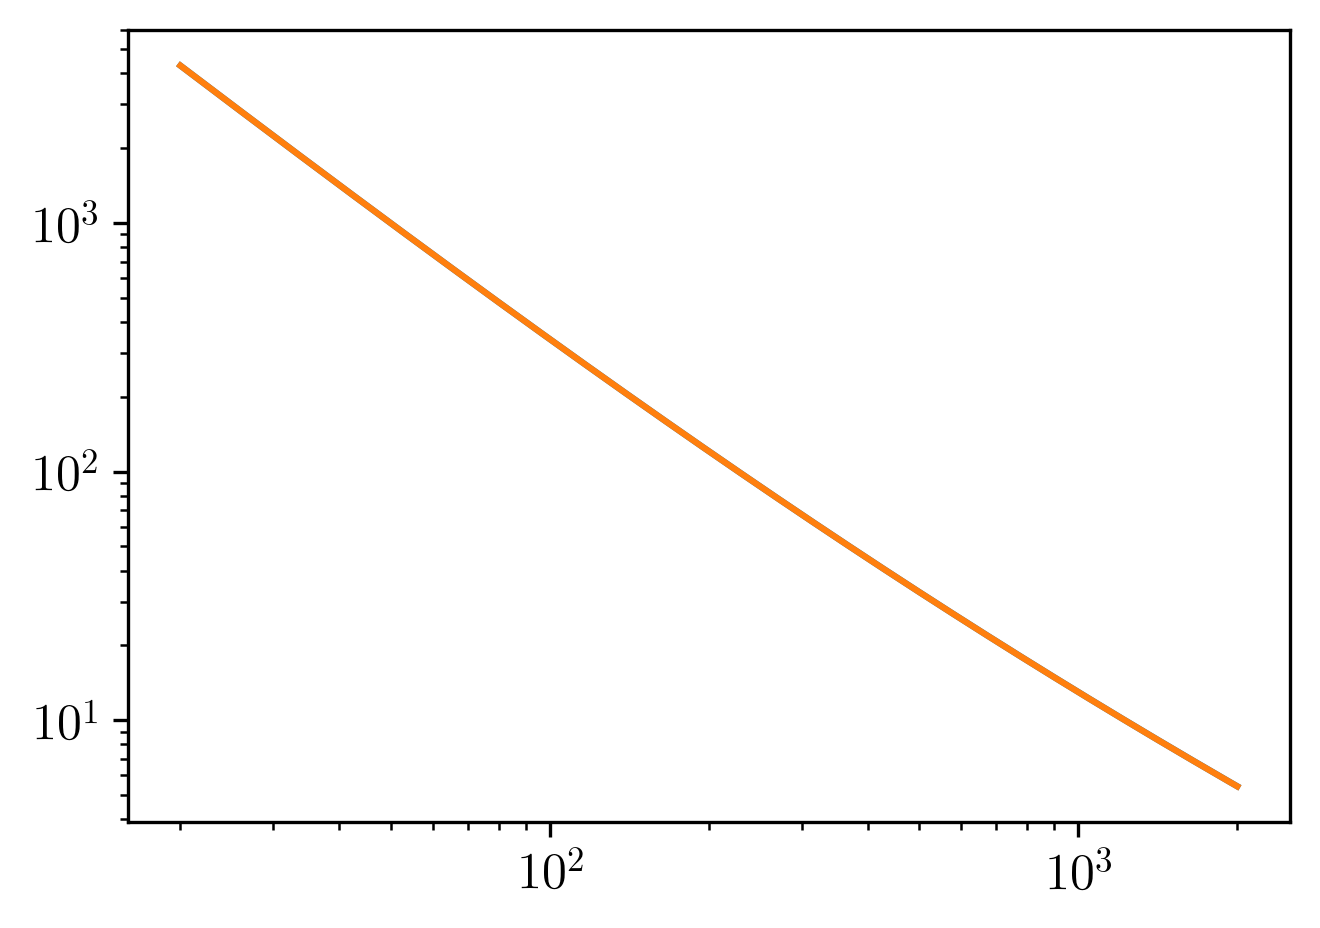

In [15]:
plt.loglog(fs, Psi(fs, theta))
plt.loglog(fs, Psi(fs, theta_alt))

In [70]:
pts = sampler(key, 3000)
etas = jax.lax.map(lambda ms: (ms[0] * ms[1]) / (ms[0] + ms[1])**2, pts)
M_tots = jax.lax.map(lambda ms: ms[0] + ms[1], pts)
gt = 4.92549094830932e-6  # GN*Msun/c**3 in seconds
v = (jnp.pi * M_tots * (10. + 1e-100) * gt) ** (1.0 / 3.0)

phase = 1 / etas / v**5 * (
    1                                              # 0PN
    + (3715.0 / 756.0 + 55.0 * etas / 9.0) * v**2  # 1PN
)

In [75]:
jax.lax.map(get_M_chirp, pts)

DeviceArray([2.47090521, 2.46911368, 2.40599832, ..., 2.51972073,
             2.41694369, 2.45702217], dtype=float64)

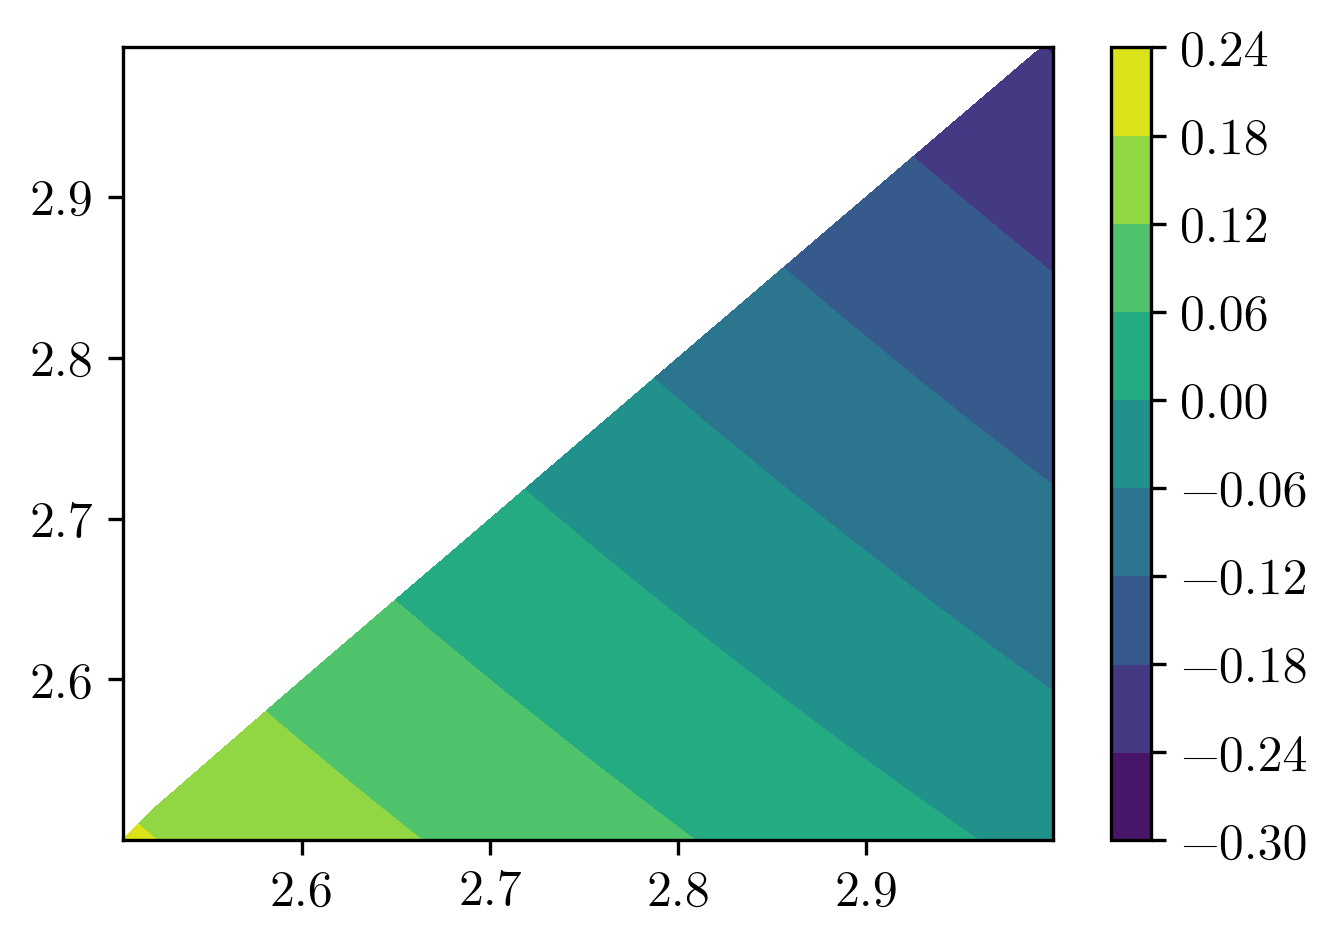

In [77]:
theta = jnp.array([2.9, 2.55])
plt.tricontourf(*pts.T, get_M_chirp(theta) - jax.lax.map(get_M_chirp, pts))
plt.colorbar()

## Density

In [53]:
key, subkey = random.split(key)
pts = sampler(subkey, 2000)
densities_0 = jax.lax.map(density_fun_0, pts)

_keys = random.split(key, len(pts) + 1)
key, subkey = _keys[0], _keys[1:]
f_ibs = jax.lax.map(
    lambda args: get_fib(args["key"], args["theta"]), {"key": subkey, "theta": pts}
)

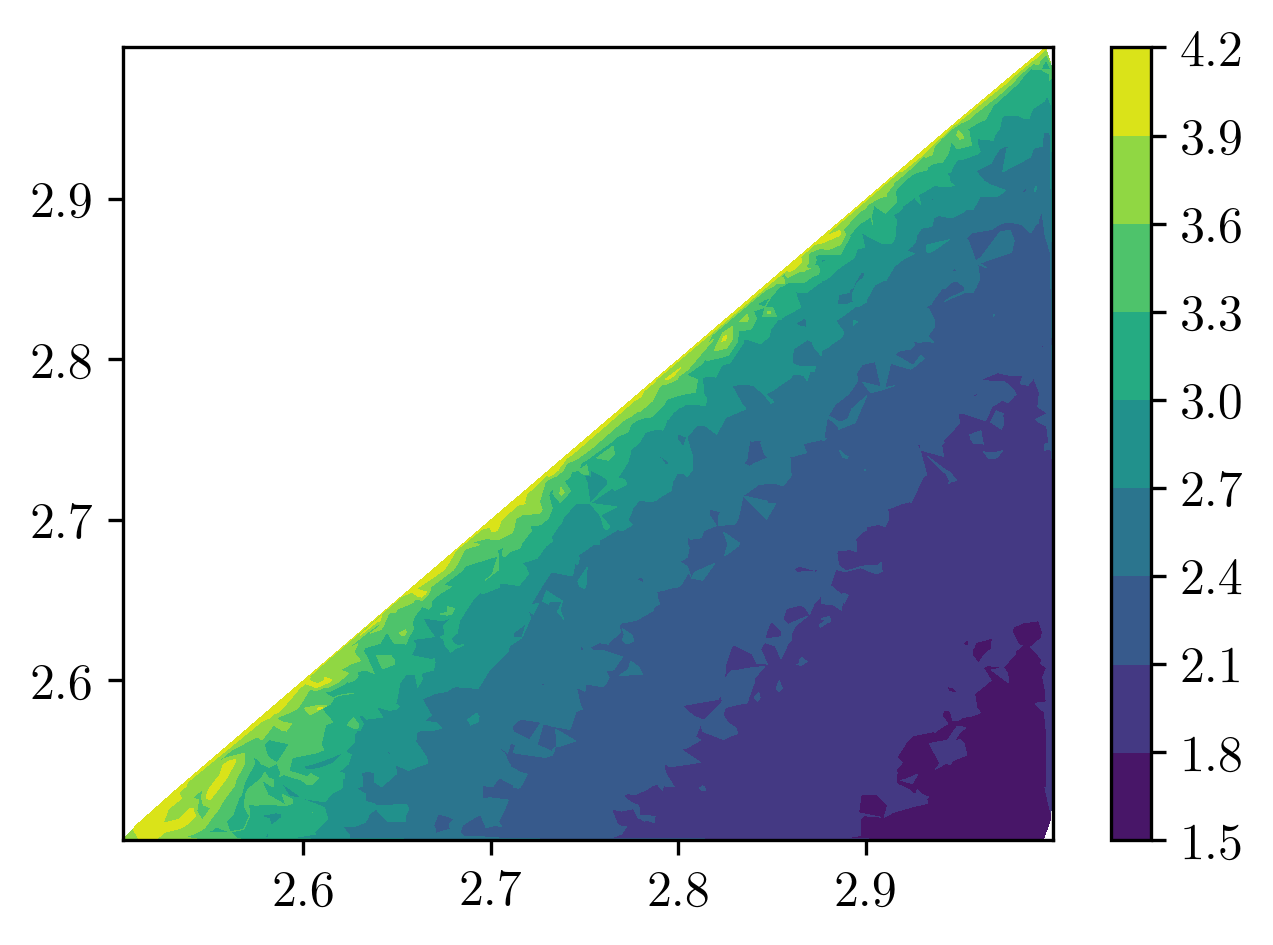

In [55]:
plt.tricontourf(*pts.T, jnp.log10(1 / f_ibs))
plt.colorbar()

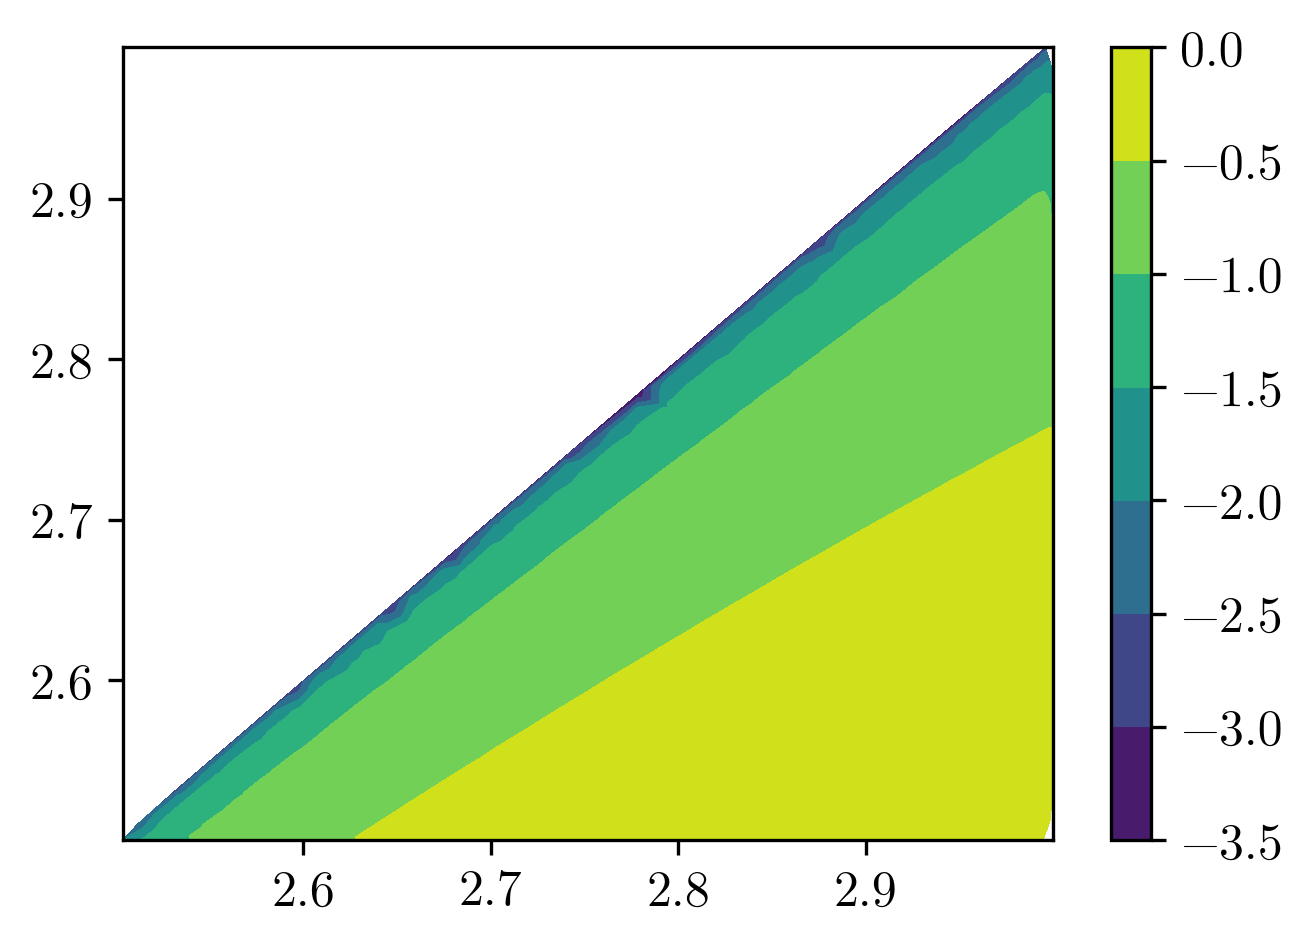

In [56]:
plt.tricontourf(*pts.T, jnp.log10(densities_0))
plt.colorbar()

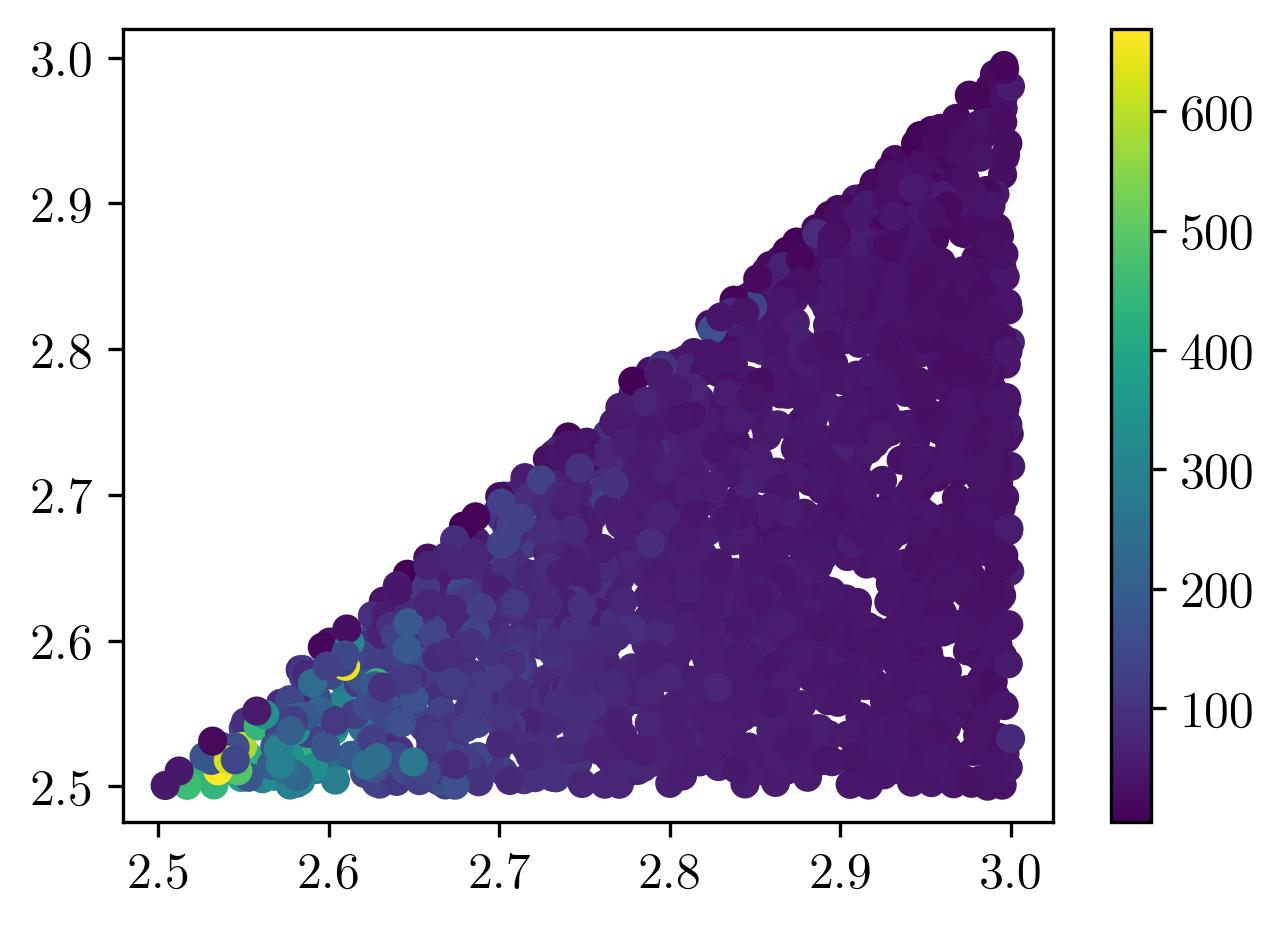

In [57]:
plt.scatter(*pts.T, c=densities_0 / f_ibs)
plt.colorbar()

## Distances: metric estimate vs match

In [12]:
theta = jnp.array([2.85, 2.54])
g = get_g(theta)
get_match_theta = jax.jit(lambda pt: get_match(pt, theta, amp, Psi, fs, Sn_aLIGO))

In [13]:
key, subkey = random.split(key)
pts = sampler(subkey, 10000)

In [14]:
matches = jax.lax.map(get_match_theta, pts)

In [16]:
diffs = theta - pts
matches_approx = 1 - jnp.einsum("ai,ij,aj->a", diffs, g, diffs)

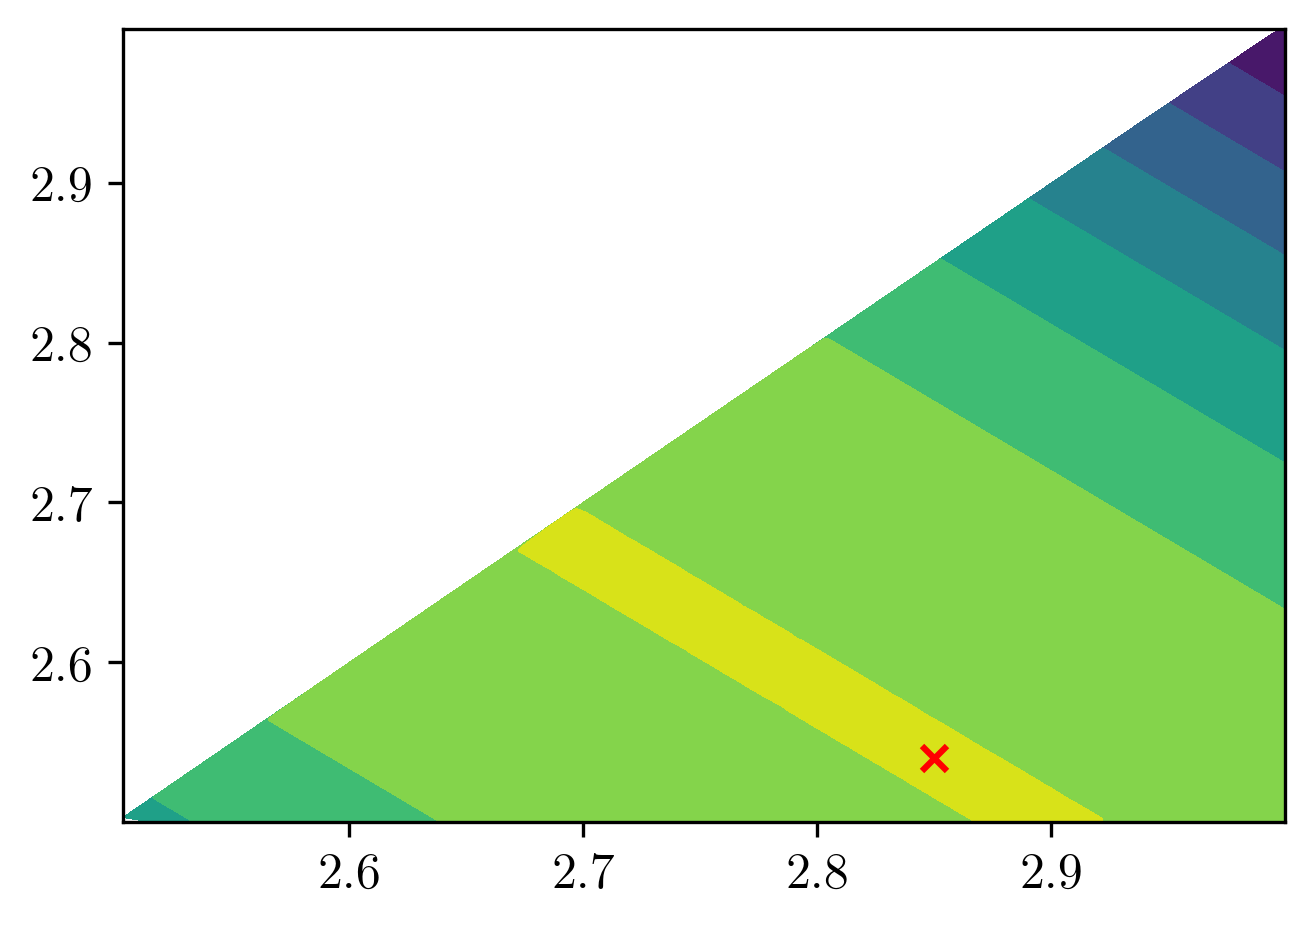

In [17]:
plt.tricontourf(*pts.T, matches_approx)#, levels=[0.8, 0.85, 0.9, 0.95, 1.])
plt.scatter(*theta, c="r", marker="x")

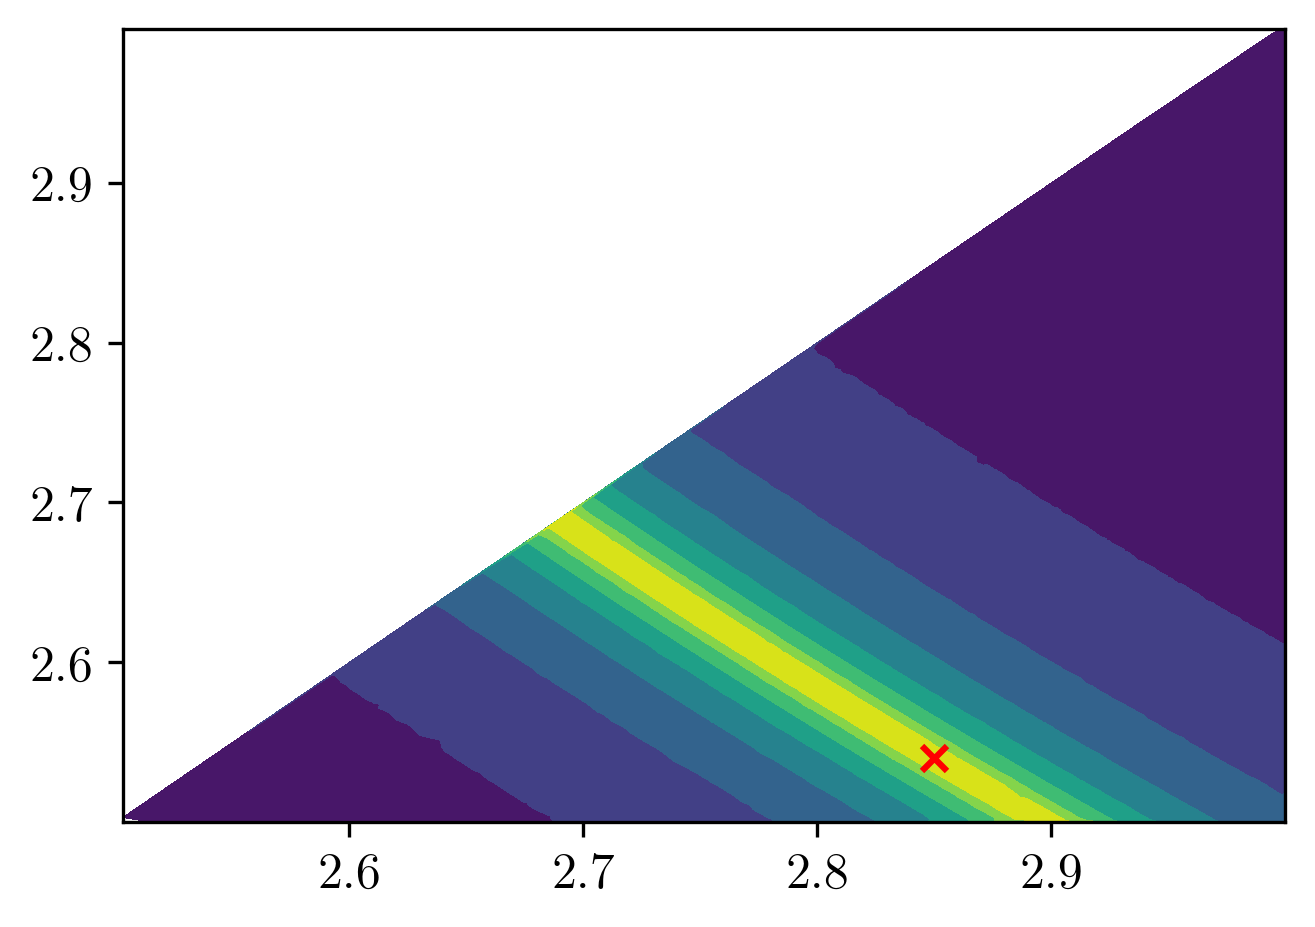

In [19]:
plt.tricontourf(*pts.T, matches)#, levels=[0.8, 0.85, 0.9, 0.95, 1.])
plt.scatter(*theta, c="r", marker="x")

## `f_IB` correction

In [81]:
from typing import Callable, Tuple

def sample_uniform_ball(key, dim, shape: Tuple[int] = (1,)) -> jnp.ndarray:
    """
    Uniformly sample from the unit ball.
    """
    xs = random.normal(key, shape + (dim,))
    abs_xs = jnp.sqrt(jnp.sum(xs ** 2, axis=-1, keepdims=True))
    sphere_samples = xs / abs_xs
    rs = random.uniform(key, shape + (1,)) ** (1 / dim)
    return sphere_samples * rs


def sample_uniform_metric_ellipse(
    key: jnp.ndarray,
    g: jnp.ndarray,
    n: int,
) -> jnp.ndarray:
    """
    Uniformly sample inside a metric ellipse centered at the origin.
    """
    dim = g.shape[1]
    # radius = jnp.sqrt(m_star)
    ball_samples = sample_uniform_ball(key, dim, (n,))
    trafo = jnp.linalg.inv(jnp.linalg.cholesky(g))
    return ball_samples @ trafo.T


def get_template_frac_in_bounds(
    key: jnp.ndarray,
    theta: jnp.ndarray,
    get_g: Callable[[jnp.ndarray], jnp.ndarray],
    m_star,
    is_in_bounds: Callable[[jnp.ndarray], jnp.ndarray],
    n: int,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Estimates average fraction of a template's metric ellipse lying inside the
    parameter space.
    Args:
      is_in_bounds: callable that takes a point and returns 1 if it is in the
        parameter space and 0 if not.
      n: number of points to sample in each template ellipse.
    Returns:
      MC estimate (along with error) of the fraction of the volume of the
      templates centered on ``theta`` that lies in the parameter space.
    """
    # Rescale metric ellipse samples to have radius ``sqrt(m_star)`` and
    # recenter on ``theta``
    ellipse_samples_0 = sample_uniform_metric_ellipse(key, get_g(theta), n)
    ellipse_samples = jnp.sqrt(m_star) * ellipse_samples_0 + theta
    in_bounds = jax.lax.map(is_in_bounds, ellipse_samples)
    return in_bounds.mean(), in_bounds.std() / jnp.sqrt(n)

In [82]:
def is_in_bounds(theta):
    m1, m2 = theta[..., 0], theta[..., 1]
    return jnp.where(
        m1 < m_range[0],
        jnp.array(0.0),
        jnp.where(
            m1 > m_range[1],
            jnp.array(0.0),
            jnp.where(
                m2 < m_range[0],
                jnp.array(0.0),
                jnp.where(m2 > m1, jnp.array(0.0), jnp.array(1.0)),
            ),
        ),
    )


get_g = lambda theta: _get_g(theta, amp, Psi, fs, Sn_aLIGO)
get_f_ib = jax.jit(
    lambda key, theta: get_template_frac_in_bounds(
        key, theta, get_g, 1 - minimum_match, is_in_bounds, 5000
    )
)

In [83]:
key, subkey = random.split(key)
pts = sampler(subkey, 1000)

In [85]:
densities = jax.lax.map(lambda theta: get_density(theta, amp, Psi, fs, Sn_aLIGO), pts)

In [86]:
_keys = random.split(key, 1 + len(pts))
key, keys_fib = _keys[0], _keys[1:]
f_ibs, f_ib_errs = jax.lax.map(
    lambda arg: get_f_ib(arg["key"], arg["theta"]), {"key": keys_fib, "theta": pts}
)

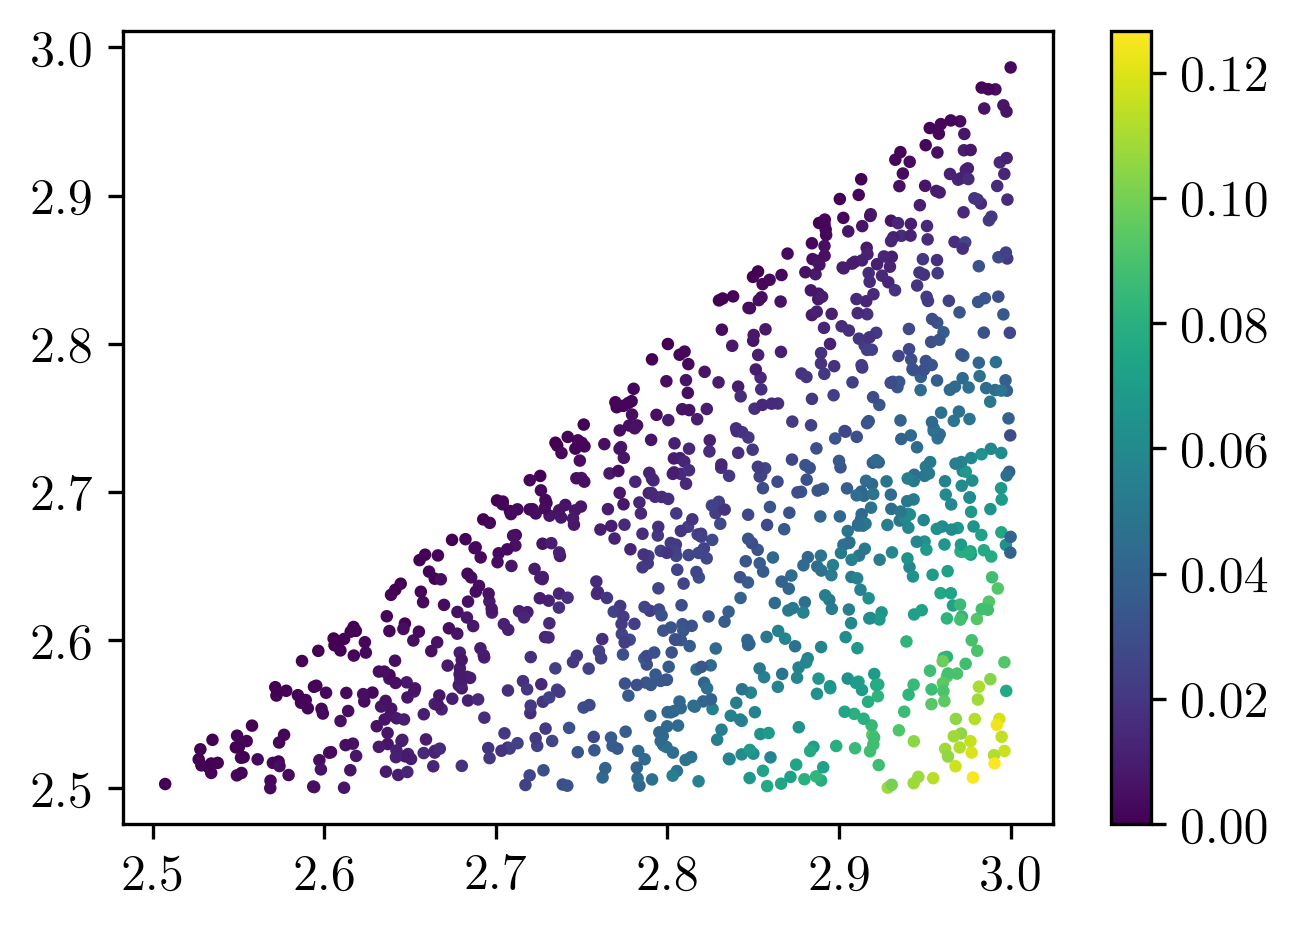

In [88]:
plt.scatter(*pts.T, s=4, c=f_ibs)
plt.colorbar()

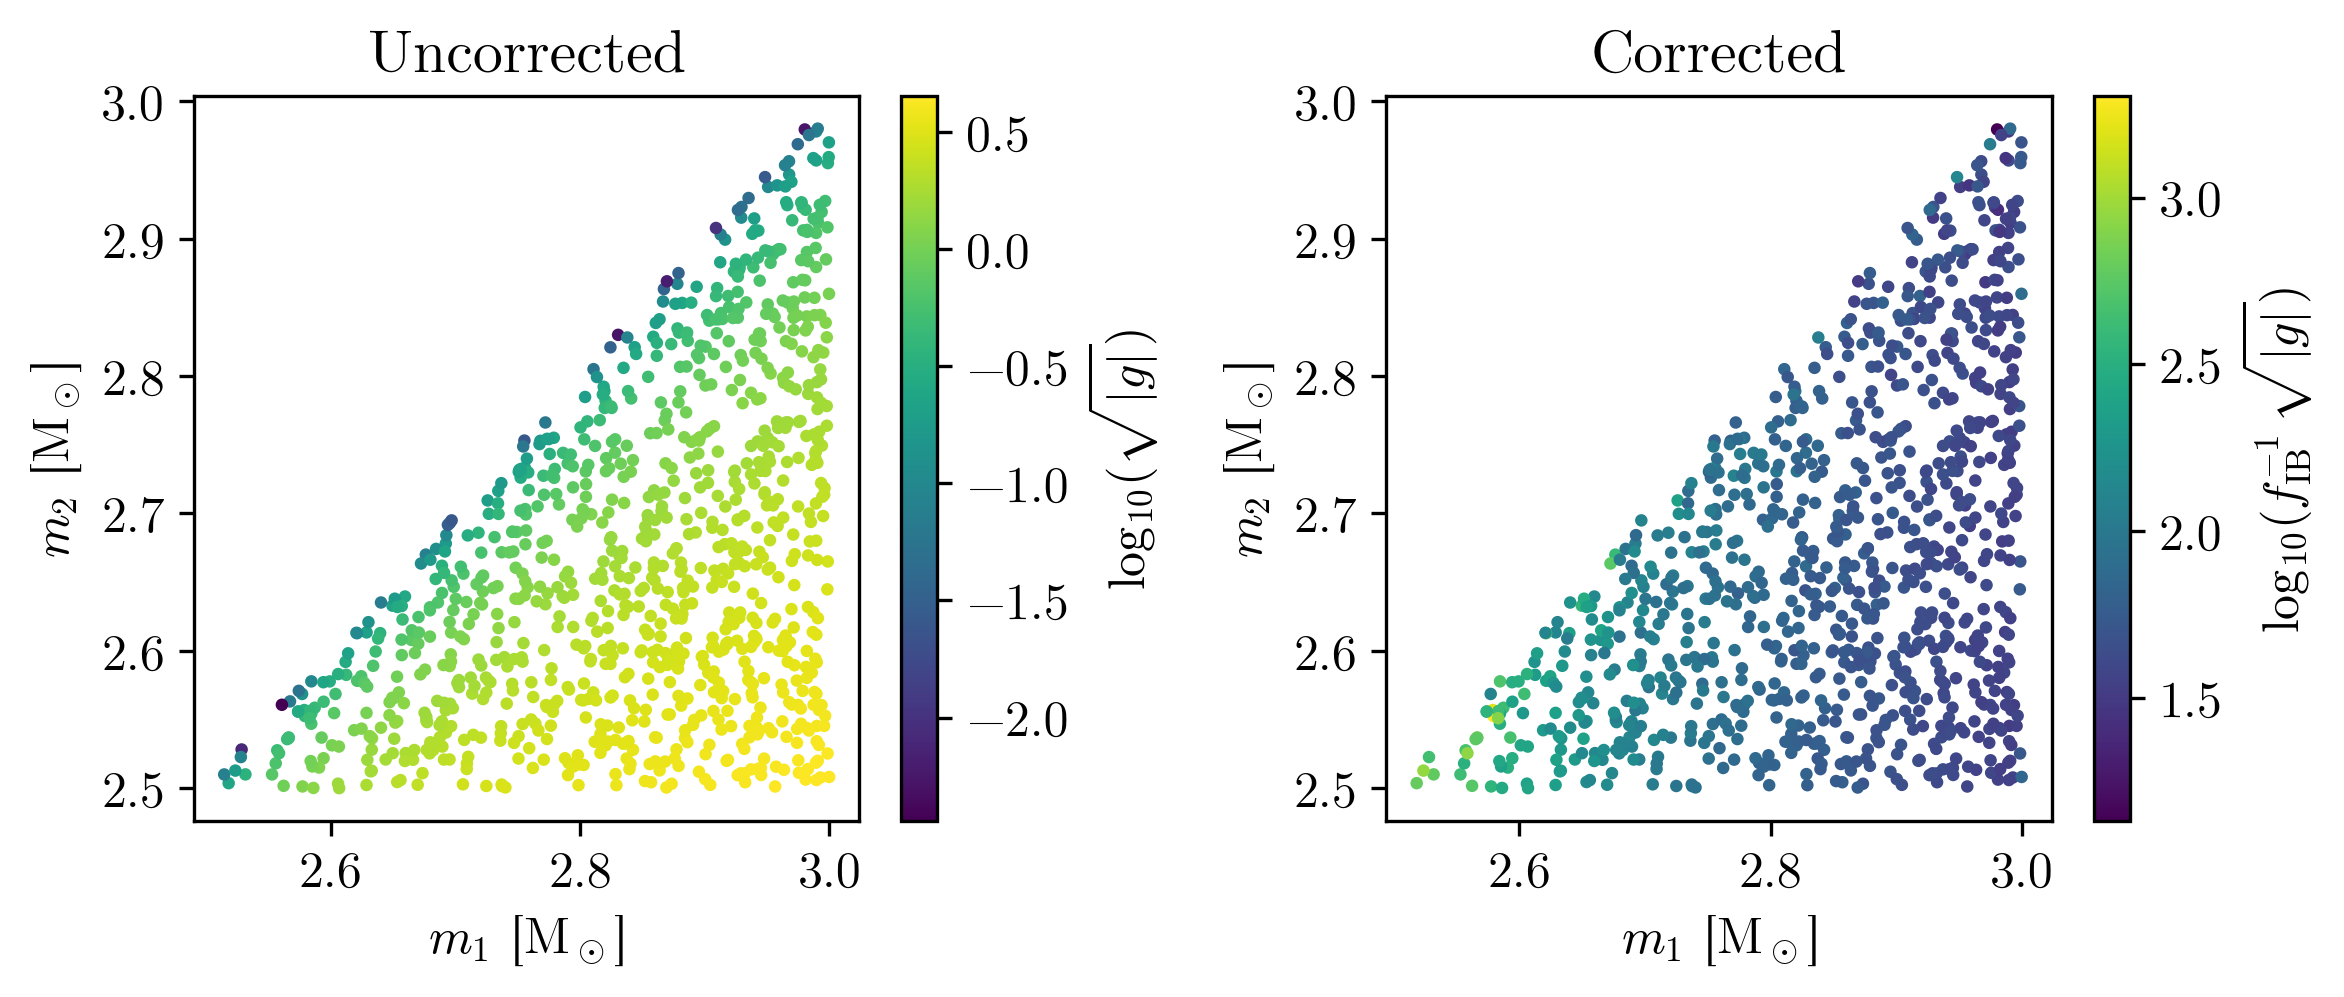

In [30]:
plt.figure(figsize=(8, 3.5))

plt.subplot(1, 2, 1)
plt.scatter(*pts.T, s=4, c=jnp.log10(densities))
plt.colorbar(label=r"$\log_{10}(\sqrt{|g|})$")
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.title("Uncorrected")

plt.subplot(1, 2, 2)
plt.scatter(*pts.T, s=4, c=jnp.log10(densities / f_ibs))
plt.colorbar(label=r"$\log_{10}(f_\mathrm{IB}^{-1} \, \sqrt{|g|})$")
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.title("Corrected")

plt.tight_layout()

In [168]:
print(get_f_ib(key, jnp.array([2.9, 2.7])))
print(get_f_ib(key, jnp.array([2.6, 2.55])))

(DeviceArray(0.03901, dtype=float64), DeviceArray(0.00061228, dtype=float64))
(DeviceArray(0.00311, dtype=float64), DeviceArray(0.00017608, dtype=float64))


In [154]:
theta = jnp.array([2.6, 2.55])
ellipse_samples_0 = sample_uniform_metric_ellipse(key, get_g(theta), n=1000)
ellipse_samples = jnp.sqrt(m_star) * ellipse_samples_0 + theta

## LazyBank

In [25]:
key, key_bank = random.split(key)
templates, eff_pts = gen_bank(
    key_bank,
    density_max,
    sampler,
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    minimum_match,
    eff_pt_sampler=lambda key: sampler(key, 1)[0],
    eta=eta_target,
    r=1,
    is_in_bounds=is_in_bounds,
    n_fib=10
)

  0%|          | 0/68 [00:00<?, ?it/s]

In [64]:
key, key_eff = random.split(key)
effs, eff_pts, eta, eta_err = get_bank_effectualness(
    key_eff,
    templates,
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    minimum_match,
    200,
#     base_dist=sampler,
#     density_max=density_max,
    eff_pt_sampler=lambda key: sampler(key, 1)[0]
)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

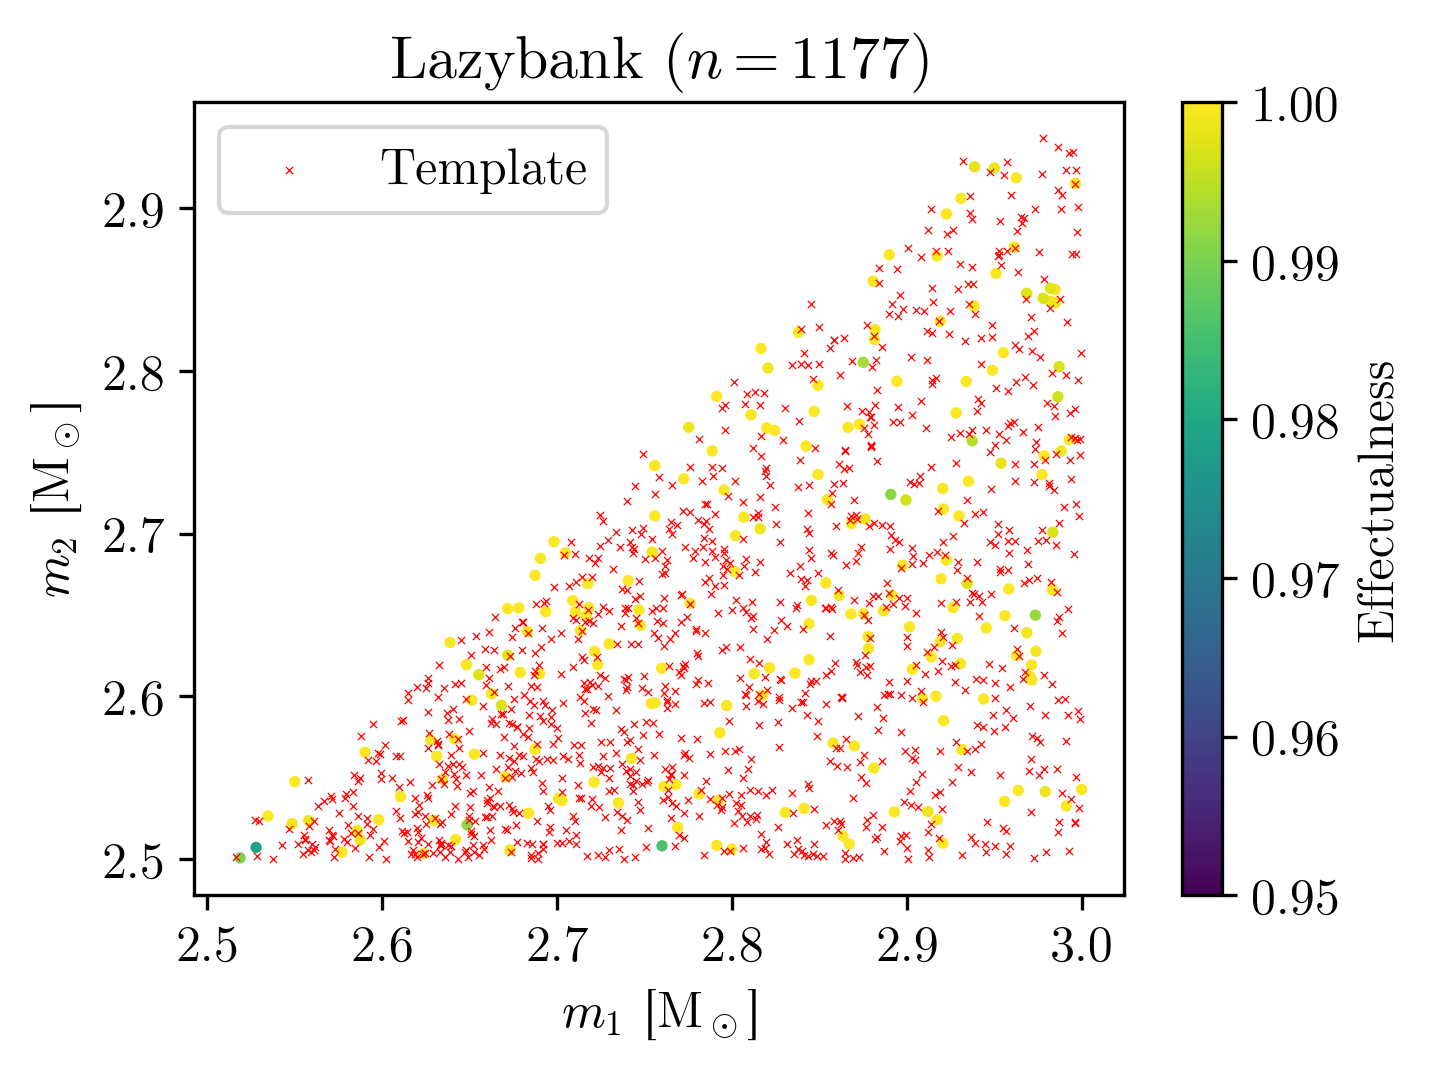

In [65]:
plt.scatter(*eff_pts.T, s=3, c=effs, vmin=minimum_match, vmax=1)
plt.colorbar(label="Effectualness")
plt.scatter(*templates.T, s=3, c="r", linewidth=0.3, marker="x", label="Template")
plt.legend()
plt.title(f"Lazybank ($n = %g$)" % len(templates))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

## Stochastic bank

In [7]:
key = random.PRNGKey(85)
key, key_bank = random.split(key)

# gen_template = jax.jit(
#     lambda key: gen_template_rejection(key, density_max, density_fun, sampler)
# )

gen_template = jax.jit(lambda key: sampler(key, 1)[0])

gen_bank_stochastic = jax.jit(
    lambda key: _gen_bank_stochastic(
        key, gen_template, amp, Psi, fs, Sn_aLIGO, minimum_match, 150
    )
)

In [8]:
templates_stochastic, n_rejects = gen_bank_stochastic(key_bank)

  1%|          | 1/150 [00:00<?, ?it/s]

In [68]:
key, key_eff = random.split(key)
(
    effs_stochastic,
    eff_pts_stochastic,
    eta_stochastic,
    eta_err_stochastic,
) = get_bank_effectualness(
    key_eff,
    templates_stochastic,
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    minimum_match,
    200,
#     base_dist=sampler,
#     density_max=density_max,
    eff_pt_sampler=lambda key: sampler(key, 1)[0]
)

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

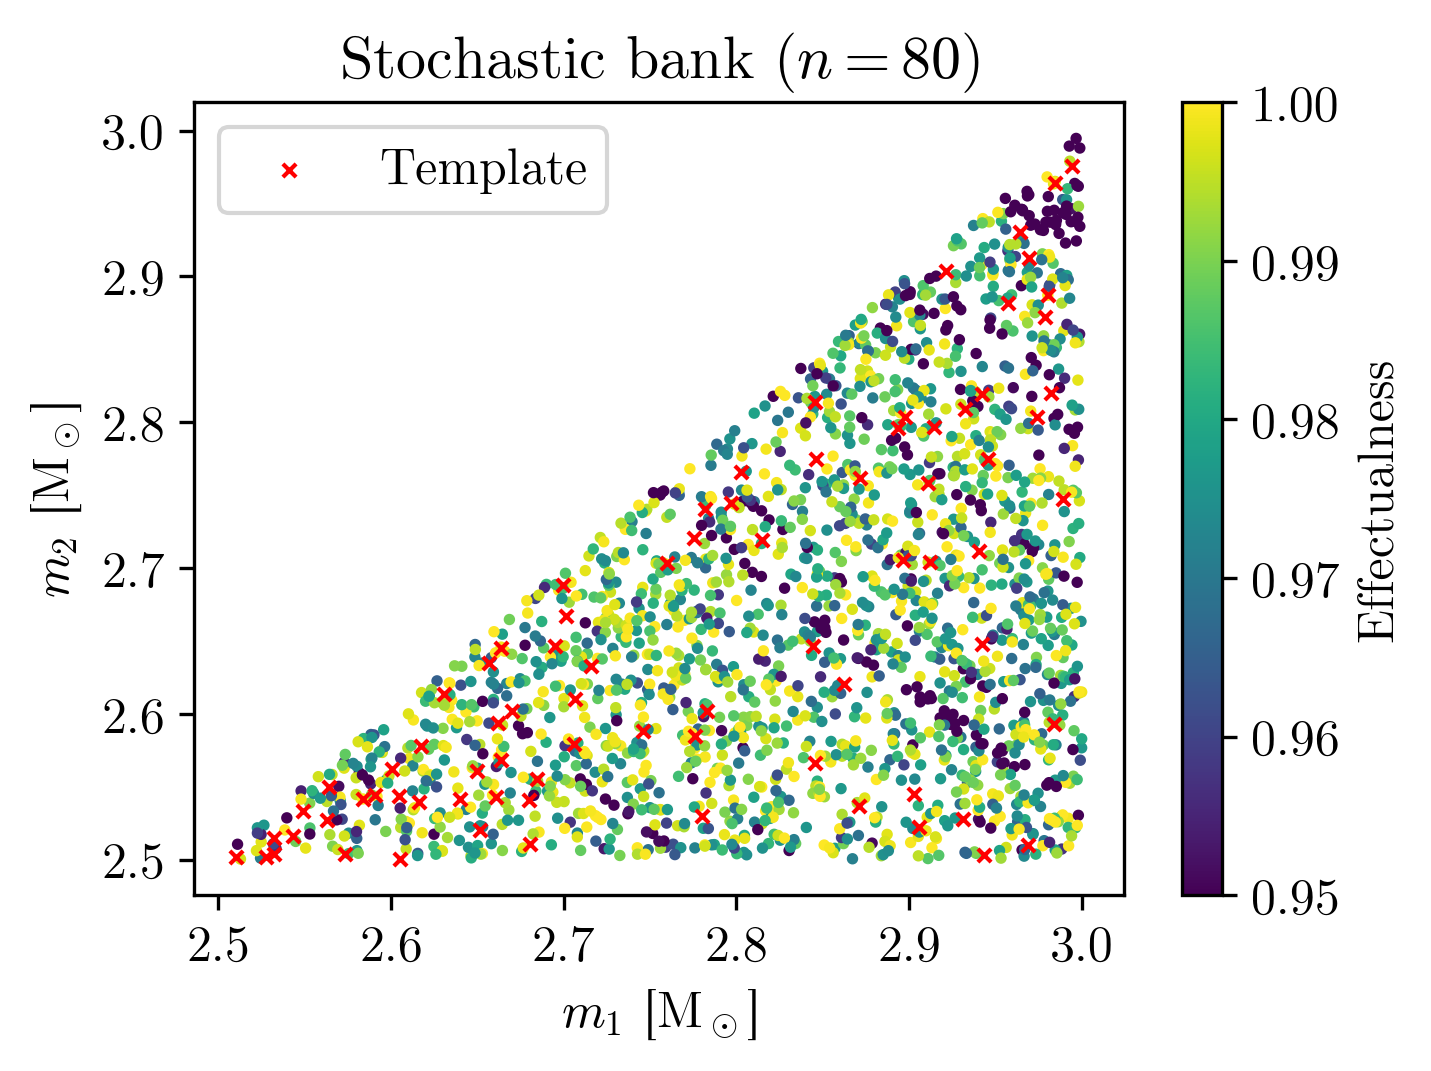

In [69]:
plt.scatter(*eff_pts_stochastic.T, s=3, c=effs_stochastic, vmin=minimum_match, vmax=1)
plt.colorbar(label="Effectualness")
plt.scatter(
    *templates_stochastic.T, s=10, c="r", linewidth=1, marker="x", label="Template"
)
plt.legend()
plt.title(f"Stochastic bank ($n = %g$)" % len(templates_stochastic))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

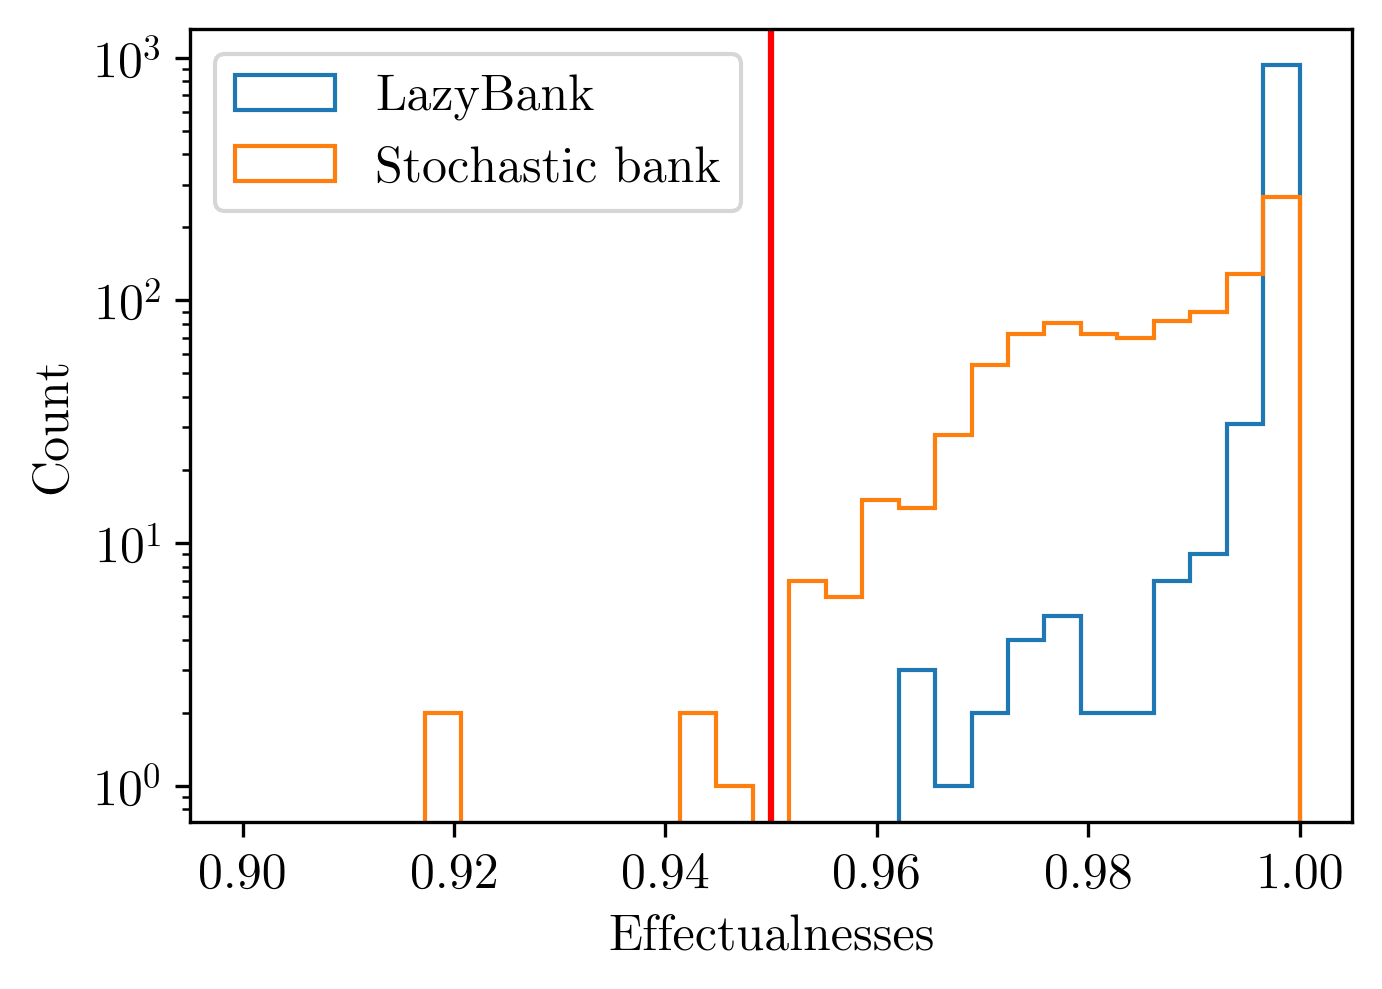

In [12]:
bins = jnp.linspace(0.9, 1.0, 30)
plt.hist(effs, histtype="step", bins=bins, label="LazyBank")
plt.hist(effs_stochastic, histtype="step", bins=bins, label="Stochastic bank")
plt.axvline(minimum_match, color="r")
plt.legend(loc="upper left")
plt.xlabel("Effectualnesses")
plt.ylabel("Count")
plt.yscale("log")

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

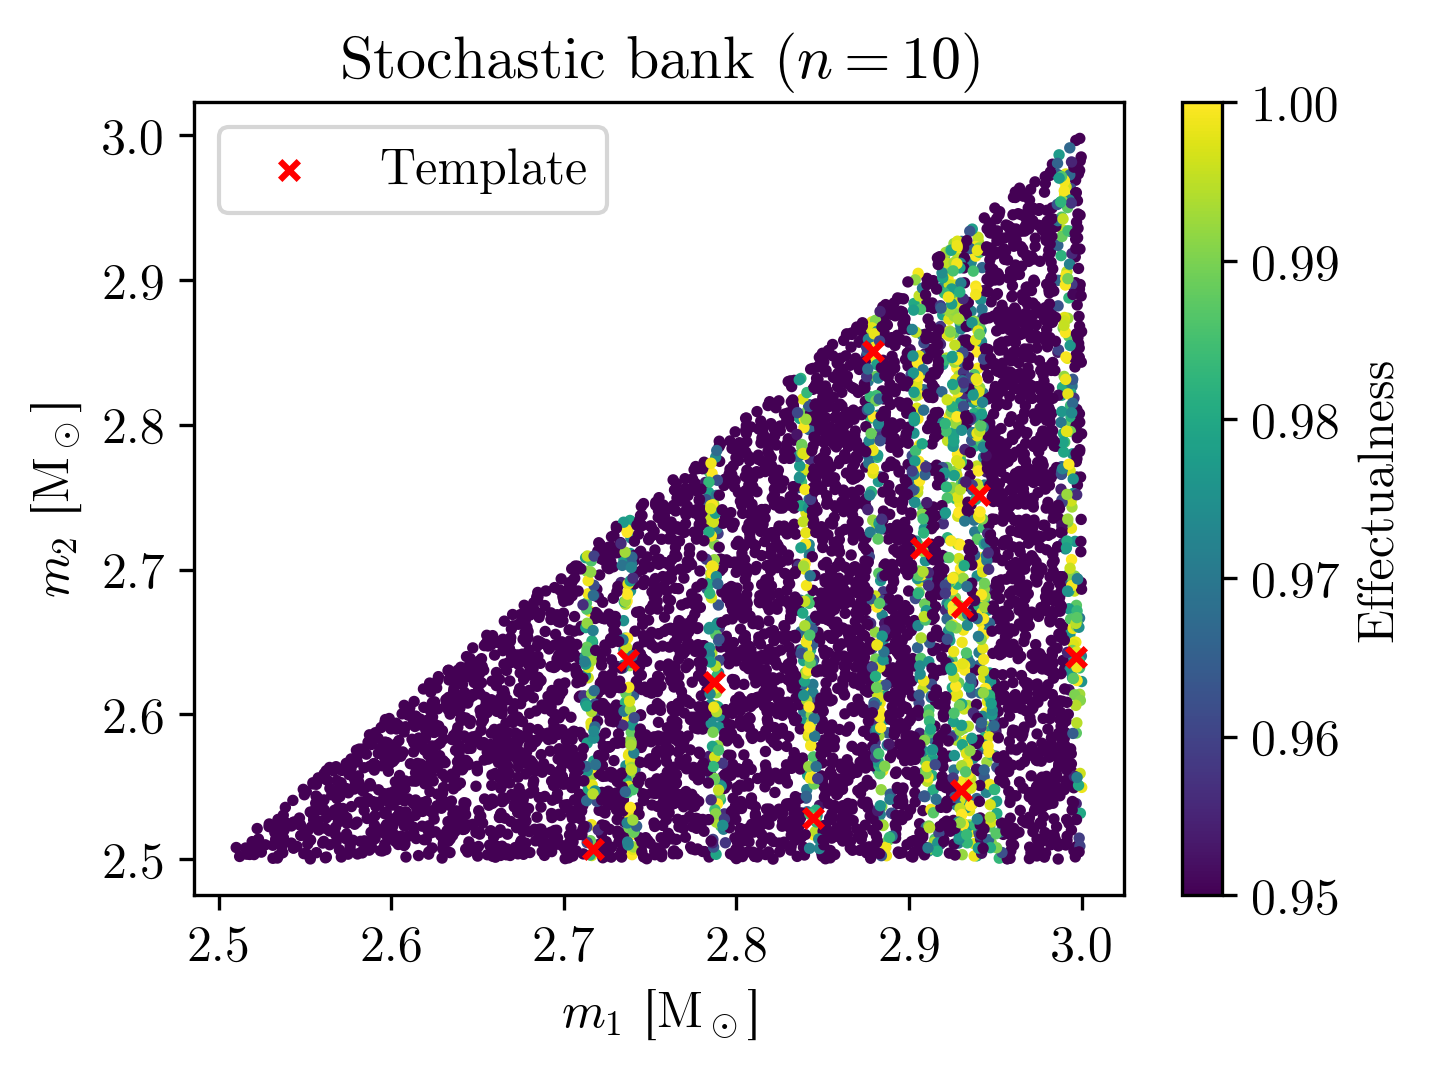

In [32]:
plt.scatter(*eff_pts_stochastic.T, s=3, c=effs_stochastic, vmin=minimum_match, vmax=1)
plt.colorbar(label="Effectualness")
plt.scatter(
    *templates_stochastic.T, s=20, c="r", linewidth=1.5, marker="x", label="Template"
)
plt.legend()
plt.title(f"Stochastic bank ($n = %g$)" % len(templates_stochastic))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")